In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils  import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt 
import pickle
import numpy as np
import os
import cv2
from skimage import io

# pickle_in = open("./X.pickle","rb")
# X= pickle.load(pickle_in)
# pickle_in.close()
# pickle_in = open("./y.pickle","rb")
# y= pickle.load(pickle_in)
# pickle_in.close()
# num_classes = 35
# y = to_categorical(y,num_classes)
# print(len(X))
# print(len(y))

# X = X/255.0
# image_size = 400













In [2]:
DATADIR = "./training_type"
LABELS = "abcdefghijklmnopqrstuvwxyz123456789"
training_data = []

def create_training_data():
    subdirs = []
    for subdir in os.listdir(DATADIR):
        subdirs.append(subdir)
        
        class_num = LABELS.index(subdir)
        for file in os.listdir(DATADIR+"/"+subdir):
            image_path = os.path.join(DATADIR+"/"+subdir,file)
            image_array = io.imread(image_path,as_gray=True)
            training_data.append([image_array,class_num])
create_training_data()

In [3]:
import random 
random.shuffle(training_data)

In [4]:
X_train = []
y_train = []

In [5]:
for features, labels in training_data:
    X_train.append(features)
    y_train.append(labels)

X_train = np.array(X_train).reshape(-1,20,20,1)
image_size = 20*20
X_train = X_train/255.0 
num_classes = 35
y_train = to_categorical(y_train,num_classes)

In [6]:
model = Sequential()
model.add( (Conv2D(64,(5,5), input_shape =X_train.shape[1:])) )
model.add(BatchNormalization())
model.add(Activation("relu") )
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2)) #20% of the nodes have a value 0 to avoid overfitting
model.add(Flatten())
model.add(Dropout(0.2))
#Dense is a non linear layer. Where it learns based on the features extracted.
#Trial and error with unit number (amount of nodes). Too many and it overfits, too little it underfits.
model.add(Dense(units=40, activation='relu', input_shape=(image_size,))) 
#The last layer is where it classifies into the different classes. Use softmax for multiple classes
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________

In [7]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=16, epochs=7, verbose=False, validation_split=0.2)
#Batch size power of 2 because of SIMD of CPUs. 
#Epochs of 9 because 20 epochs overfit my data, starts to overfit at 10
#Validation split to conform to 80-20 convention of training:validation

[0.30692166, 0.68214935, 0.8137523, 0.8693078, 0.9025501, 0.92030966, 0.9330601]
[0.571949, 0.74863386, 0.84517306, 0.8579235, 0.88160294, 0.8943534, 0.89799637]


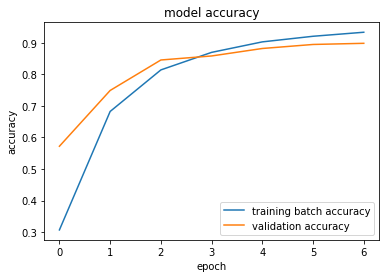

In [8]:
print(history.history['acc'])
print(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training batch accuracy', 'validation accuracy'], loc='best')
plt.show()

In [9]:
test_data = []
alpha_str = "abcdefghijklmnopqrstuvwxyz123456789"
TEST_LABELS = "NvidiasgraphicschipsarentusedjustforgamesanymoreSincethecompanymadeitschipsprogrammabletheyaretakingonfunctionsthatIntelmicroprocessorsdoAndmorethanevertheyarebeingusedforBigDatanumbercrunchingandsolvingproblemsthatpreviouslyhadtobedonebynongraphicssupercomputers".lower()
print(len(TEST_LABELS))
def create_test_data():
    DATADIR = "./testing_type"
    sorted_files = []
    
    for file in sorted(os.listdir(DATADIR), key = lambda x: int(x[:x.index("_")])):
        sorted_files.append(file)
    
    count = 0
    for file in sorted_files[:len(TEST_LABELS)]:
        
        class_num = alpha_str.index(TEST_LABELS[count])
        image_path = os.path.join(DATADIR,file)
        image = io.imread(image_path,as_gray=True)
        test_data.append([image,class_num])
        count+=1

create_test_data()

263


In [10]:
X_test = []
y_test = []

for features, labels in test_data:
    X_test.append(features)
    y_test.append(labels)

X_test = np.array(X_test).reshape(-1,20,20,1)

num_classes = 35
y_test = to_categorical(y_test, num_classes)

X_test = X_test/255.0

Predicted string: nvlbiasgraphlcschlpsarentusebjustforgamesanymoreslncethecompanymabeitschipsprogrammabietheyaretaklngonfunctlonsthatinteimicroprocessorsboandmorethanevertheyarebeingusedforblgdatanumbercrunchinganbsoivlngprobiemsthatpreviousiyhabtobebonebynongraphlcssupercomputers

Actual string: nvidiasgraphicschipsarentusedjustforgamesanymoresincethecompanymadeitschipsprogrammabletheyaretakingonfunctionsthatintelmicroprocessorsdoandmorethanevertheyarebeingusedforbigdatanumbercrunchingandsolvingproblemsthatpreviouslyhadtobedonebynongraphicssupercomputers


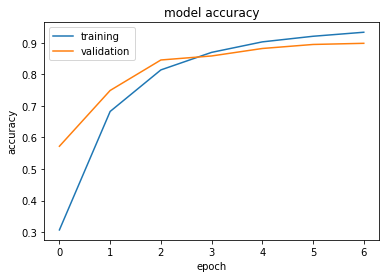


Test loss: 0.156
Test accuracy: 0.92


In [11]:
loss, accuracy = model.evaluate(X_test,y_test, verbose=False)

result = model.predict_classes(X_test)
print("Predicted string:", "".join([LABELS[letter] for letter in result]))
print()
print("Actual string:",TEST_LABELS)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print()
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

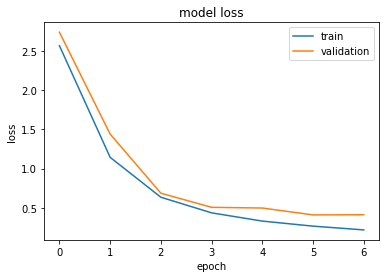

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
##Not as sharp decrease in loss because it is trained with different fonts. 
##Russian was trained with one font

In [16]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21340a16ac8>)

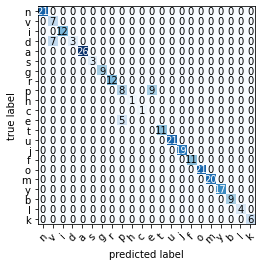

In [30]:
matrix = confusion_matrix(y_test,result)
TEST_LABELS = "NvidiasgraphicschipsarentusedjustforgamesanymoreSincethecompanymadeitschipsprogrammabletheyaretakingonfunctionsthatIntelmicroprocessorsdoAndmorethanevertheyarebeingusedforBigDatanumbercrunchingandsolvingproblemsthatpreviouslyhadtobedonebynongraphicssupercomputers".lower()
unique_letters = []
for letter in TEST_LABELS:
    if letter not in unique_letters:
        unique_letters.append(letter)
plot_confusion_matrix(conf_mat=matrix, class_names = unique_letters)